In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [3]:
x = np.array( df.iloc[:, df.columns != 'output'])
y = np.array(df.iloc[:, -1])

print(x.shape)
print(y.shape)

(303, 13)
(303,)


In [4]:
X_train, X_test,y_train, y_test = train_test_split(x,y, train_size=0.8, random_state=42)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape[1]

13

In [6]:
architecture = [
    {"input_dim": X_train.shape[1], "output_dim": 28, "activation": "relu"},
    {"input_dim": 28, "output_dim": 64, "activation": "relu"},
    {"input_dim": 64, "output_dim": 128, "activation": "relu"},
    {"input_dim": 128, "output_dim": 28, "activation": "relu"},
    {"input_dim": 28, "output_dim": 1, "activation": "sigmoid"},
]

In [7]:
def init_layers(nn_architecture, val = 99):
    np.random.seed(val)
    params_values = {}
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1

        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]

        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

In [8]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def dsigmoid(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def drelu(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

In [9]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    if activation == "relu":
        activation_func = relu
    elif activation == "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')

    return activation_func(Z_curr), Z_curr

In [10]:
def full_forward_propagation(X, params_values, nn_architecture):
    memory = {}
    A_curr = X
    
    for idx, layer in enumerate(nn_architecture):
        layer_idx = idx + 1
        A_prev = A_curr

        activ_function_curr = layer["activation"]
        W_curr = params_values["W" + str(layer_idx)]
        b_curr = params_values["b" + str(layer_idx)]
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)

        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    return A_curr, memory

In [11]:
def get_cost_value(Y_hat, Y):
    m = Y_hat.shape[1]
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

In [12]:
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [13]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

In [14]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    if activation == "relu":
        backward_activation_func = drelu
    elif activation == "sigmoid":
        backward_activation_func = dsigmoid
    else:
        raise Exception('Non-supported activation function')
 
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

In [ ]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}

    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        layer_idx_curr = layer_idx_prev + 1
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

In [16]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    for layer_idx, layer in enumerate(nn_architecture, 1):
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

In [17]:
def train(X, Y, nn_architecture, epochs, learning_rate):
    
    params_values = init_layers(nn_architecture, 2)
    cost_history = []
    accuracy_history = []
    
    for i in range(epochs):
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
    return params_values, cost_history, accuracy_history

In [18]:
params_values,cost, acc = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0]),1)), architecture, 10000, 0.01)

In [19]:
Y_test_hat, fill = full_forward_propagation(np.transpose(X_test), params_values, architecture)
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print(acc_test)

0.8360655737704918


[Text(0.5, 1.0, 'train Lost')]

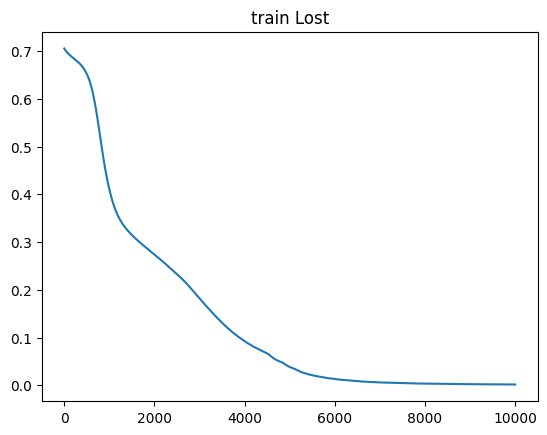

In [20]:
loss = np.transpose(cost)
sns.lineplot(x=list(range(len(loss))), y= loss).set(title='train Lost')